In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, fbeta_score

import torch
from torch import nn

from Autoencoders import *
from DataPreprocessing import *

# Data preprocessing

In [5]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

csv_path = '/content/drive/MyDrive/creditcard.csv'
seed = 777
batch_size = 32
n_splits = 5
# train_loader, test_loader, y_test, input_dim = Data_preprocessing(csv_path, seed, batch_size, n_splits)
splits = Data_preprocessing(csv_path, seed, batch_size, n_splits)

Using device: cuda
Fold 1
  Training data size: 227452
  Testing data size: 57355
  Labels 0 in training data: 227452
  Labels 1 in testing data: 492
Fold 2
  Training data size: 227452
  Testing data size: 57355
  Labels 0 in training data: 227452
  Labels 1 in testing data: 492
Fold 3
  Training data size: 227452
  Testing data size: 57355
  Labels 0 in training data: 227452
  Labels 1 in testing data: 492
Fold 4
  Training data size: 227452
  Testing data size: 57355
  Labels 0 in training data: 227452
  Labels 1 in testing data: 492
Fold 5
  Training data size: 227452
  Testing data size: 57355
  Labels 0 in training data: 227452
  Labels 1 in testing data: 492


# Train model function

In [6]:
def train_model(model, dataloader, criterion, optimizer):

    model.train()
    total_loss = 0

    for data, _ in dataloader:
        data = data.to(device)

        if isinstance(model, AutoEncoder):
            decoded = model(data)
            loss = criterion(decoded, data)

        elif isinstance(model, SparseAutoEncoder):
            decoded, encoded = model(data)
            loss = model.sparse_loss(criterion, decoded, data, encoded)

        elif isinstance(model, VariationalAutoEncoder):
            decoded, mu, logvar = model(data)
            loss = model.vae_loss(criterion, decoded, data, mu, logvar)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss += loss.item() * data.size(0)

    return total_loss / len(dataloader.dataset)


# Evaluate model function

In [7]:
def evaluate_model(model, dataloader, criterion):

    model.eval()
    total_loss = 0
    all_labels = []
    all_scores = []

    with torch.inference_mode():

        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.cpu().numpy()

            if isinstance(model, AutoEncoder):
                decoded = model(data)
                loss = criterion(decoded, data)
            elif isinstance(model, SparseAutoEncoder):
                decoded, _ = model(data)
                loss = criterion(decoded, data)
            elif isinstance(model, VariationalAutoEncoder):
                decoded, mu, logvar = model(data)
                loss = model.vae_loss(criterion, decoded, data, mu, logvar)

            total_loss += loss.item() * data.size(0)
            all_labels.extend(labels)
            all_scores.extend(loss.cpu().numpy() for _ in range(data.size(0)))

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss, all_labels, all_scores

# XV model funciton

In [8]:
def cross_validate_model(model_class, splits, learning_rate, epochs, threshold=None):
    fold_train_losses = []
    fold_val_losses = []
    all_labels = []
    all_scores = []

    for fold, (train_loader, val_loader, y_val, input_dim) in enumerate(splits):
        if model_class == SparseAutoEncoder:
            model = model_class(input_dim, sparsity_target=0.1, sparsity_weight=0.1)
        else:
            model = model_class(input_dim)

        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            train_loss = train_model(model, train_loader, criterion, optimizer)
            val_loss, val_labels, val_scores = evaluate_model(model, val_loader, criterion)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f'Fold {fold + 1}, Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print('\n')

        if threshold is None and fold == 0:
            threshold = np.percentile(val_scores, 95)

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        all_labels.extend(val_labels)
        all_scores.extend(val_scores)

    avg_train_losses = np.mean(fold_train_losses, axis=0)
    avg_val_losses = np.mean(fold_val_losses, axis=0)

    return avg_train_losses, avg_val_losses, all_labels, all_scores, threshold


# Loop for all AutoEncoders and XV

In [9]:
learning_rate = 0.001
epochs = 10

model_classes = [AutoEncoder, SparseAutoEncoder, VariationalAutoEncoder]
results = {}
train_losses_dict = {}
val_losses_dict = {}
metrics_dict = {}

hard_threshold = None

for model_class in model_classes:
    print(f'\nEvaluating {model_class.__name__}')
    avg_train_losses, avg_val_losses, all_labels, all_scores, hard_threshold = cross_validate_model(model_class, splits, learning_rate, epochs, hard_threshold)
    train_losses_dict[model_class.__name__] = avg_train_losses
    val_losses_dict[model_class.__name__] = avg_val_losses

    # Compute basic metrics
    # threshold = np.percentile(all_scores, 95)  # Example threshold
    predictions = (np.array(all_scores) > hard_threshold).astype(int)
    accuracy = accuracy_score(all_labels, predictions)
    precision = precision_score(all_labels, predictions)
    recall = recall_score(all_labels, predictions)
    f1 = f1_score(all_labels, predictions)

    metrics_dict[model_class.__name__] = (accuracy, precision, recall, f1)


Evaluating AutoEncoder
Fold 1, Epoch [1/10], Train Loss: 0.9457, Val Loss: 1.1210
Fold 1, Epoch [2/10], Train Loss: 0.9134, Val Loss: 1.1046
Fold 1, Epoch [3/10], Train Loss: 0.8983, Val Loss: 1.0892
Fold 1, Epoch [4/10], Train Loss: 0.8851, Val Loss: 1.0820
Fold 1, Epoch [5/10], Train Loss: 0.8807, Val Loss: 1.0787
Fold 1, Epoch [6/10], Train Loss: 0.8787, Val Loss: 1.0772
Fold 1, Epoch [7/10], Train Loss: 0.8768, Val Loss: 1.0751
Fold 1, Epoch [8/10], Train Loss: 0.8752, Val Loss: 1.0747
Fold 1, Epoch [9/10], Train Loss: 0.8733, Val Loss: 1.0740
Fold 1, Epoch [10/10], Train Loss: 0.8720, Val Loss: 1.0745


Fold 2, Epoch [1/10], Train Loss: 0.9424, Val Loss: 1.1651
Fold 2, Epoch [2/10], Train Loss: 0.8988, Val Loss: 1.1417
Fold 2, Epoch [3/10], Train Loss: 0.8881, Val Loss: 1.1357
Fold 2, Epoch [4/10], Train Loss: 0.8834, Val Loss: 1.1326
Fold 2, Epoch [5/10], Train Loss: 0.8808, Val Loss: 1.1314
Fold 2, Epoch [6/10], Train Loss: 0.8783, Val Loss: 1.1313
Fold 2, Epoch [7/10], Train L

In [20]:
import pickle

# Save the dictionary to a file
with open('metrics_dict.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)

# Load the dictionary from the file
with open('metrics_dict.pkl', 'rb') as f:
    loaded_metrics_dict = pickle.load(f)

print(loaded_metrics_dict)

{'AutoEncoder': (0.9592537703774736, 0.17368234877962505, 0.9979674796747967, 0.29587225067791506), 'SparseAutoEncoder': (0.9583610844738907, 0.17059273156834132, 0.9979674796747967, 0.2913773663284078), 'VariationalAutoEncoder': (0.947872025106791, 0.14110006322202426, 0.9979674796747967, 0.2472430635983685)}


#

# Plot losses and metrics

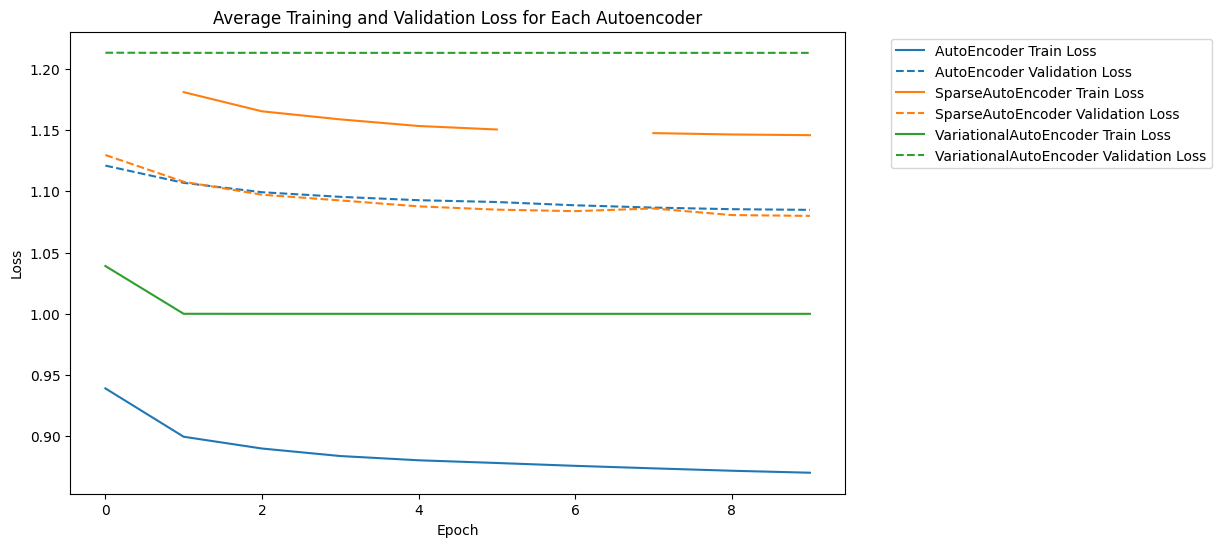

AutoEncoder Metrics:
Accuracy: 0.9593
Precision: 0.1737
Recall: 0.9980
F1 Score: 0.2959

SparseAutoEncoder Metrics:
Accuracy: 0.9584
Precision: 0.1706
Recall: 0.9980
F1 Score: 0.2914

VariationalAutoEncoder Metrics:
Accuracy: 0.9479
Precision: 0.1411
Recall: 0.9980
F1 Score: 0.2472

AutoEncoder F2-Score: 0.4506
SparseAutoEncoder F2-Score: 0.4506
VariationalAutoEncoder F2-Score: 0.4506


In [13]:
# Plot training and validation losses for each autoencoder
plt.figure(figsize=(10, 6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get default color cycle

for i, (model_name, losses) in enumerate(train_losses_dict.items()):
    plt.plot(losses, color=colors[i], label=f'{model_name} Train Loss')
    plt.plot(val_losses_dict[model_name], color=colors[i], linestyle='--', label=f'{model_name} Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss for Each Autoencoder')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Print average metrics for each autoencoder
for model_name, (accuracy, precision, recall, f1) in metrics_dict.items():
    print(f'{model_name} Metrics:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}\n')

# Utilizing F-beta score
beta = 2
for model_name, (accuracy, precision, recall, f1) in metrics_dict.items():
    fbeta = fbeta_score(all_labels, predictions, beta=beta)
    print(f'{model_name} F{beta}-Score: {fbeta:.4f}')

In [ ]:
# XV OC-SVM
# def cross_validate_ocsvm(splits, threshold=None):
#     all_labels = []
#     all_scores = []
#     accuracies = []
#     precisions = []
#     recalls = []
#     f1s = []

#     for fold, (train_loader, val_loader, y_val, input_dim) in enumerate(splits):
#         train_data = train_loader.dataset.tensors[0].cpu().numpy()
#         test_data = val_loader.dataset.tensors[0].cpu().numpy()

#         ocsvm = OneClassSVM(gamma='auto').fit(train_data)
#         y_pred = ocsvm.predict(test_data)
#         y_pred = np.where(y_pred == 1, 0, 1)  # Convert OCSVM output: 1->0 (normal), -1->1 (anomaly)

#         all_labels.extend(y_val)
#         all_scores.extend(y_pred)

#         accuracy = accuracy_score(y_val, y_pred)
#         precision = precision_score(y_val, y_pred)
#         recall = recall_score(y_val, y_pred)
#         f1 = f1_score(y_val, y_pred)

#         accuracies.append(accuracy)
#         precisions.append(precision)
#         recalls.append(recall)
#         f1s.append(f1)

#         print(f' {fold+1} done for OC-SVM!')

#     avg_accuracy = np.mean(accuracies)
#     avg_precision = np.mean(precisions)
#     avg_recall = np.mean(recalls)
#     avg_f1 = np.mean(f1s)

#     fpr, tpr, _ = roc_curve(all_labels, all_scores)
#     roc_auc = auc(fpr, tpr)

#     return avg_accuracy, avg_precision, avg_recall, avg_f1, fpr, tpr, roc_auc, threshold
# # Cross-validate One-Class SVM
# print('\nEvaluating One-Class SVM')
# ocsvm_accuracy, ocsvm_precision, ocsvm_recall, ocsvm_f1, ocsvm_fpr, ocsvm_tpr, ocsvm_roc_auc, hard_threshold = cross_validate_ocsvm(splits, hard_threshold)

# metrics_dict['OneClassSVM'] = (ocsvm_accuracy, ocsvm_precision, ocsvm_recall, ocsvm_f1)

# # Plot ROC curve for One-Class SVM
# plt.figure()
# plt.plot(ocsvm_fpr, ocsvm_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {ocsvm_roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic - One-Class SVM')
# plt.legend(loc='lower right')
# plt.show()